In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap

In [2]:
def new_grid(m, n, empty_ratio=0.1):
    '''
    Set up a new grid with some empty spaces.
    empty_ratio: proportion of the grid to be left unpopulated
    '''
    grid = np.ones([m, n])
    num_empty = int(n * m * empty_ratio)
    
    # Randomly assign empty spaces
    empty_positions = np.random.choice(n * m, num_empty, replace=False)
    for idx in empty_positions:
        # Set row index to be integer division by m, remainder is column index 
        grid[idx // m, idx % m] = np.nan 
    
    return grid

def add_amenities(grid, amenities):
    '''
    Add amenities to unpopulated spaces.
    '''
    # Get empty position indices by looking for NaNs
    empty_positions = np.argwhere(np.isnan(grid))
    
    # Number of amenities set to be minimum of entered argument and number of empty slots
    num_amenities = min(amenities, len(empty_positions))
    # Randomly choose from empty slots
    amenity_indices = np.random.choice(len(empty_positions), num_amenities, replace=False)
    # We can remove tgis line later
    print(f"Positions to add amenities: {amenity_indices}")
    
    # Iterate through chosen empty positions to set amenity values
    for idx in amenity_indices:
        position = empty_positions[idx]
        # Use -1 to represent an amenity 
        # This should work since houses will never have a negative price
        grid[position[0], position[1]] = -1  
    
    return grid

def initial_price_dist(m, n, v, amenities, empty_ratio=0.1):
    '''
    Initialize grid with prices, unpopulated spaces and amenities 
    '''
    houses = v * new_grid(m, n, empty_ratio)
    # Add "amenities" number of amenities within the empty grid points
    houses = add_amenities(houses, amenities)

    return houses


def plot_grid(grid):
    '''
    Plot grid with unpopulated squares in gray, amenities in blue, and high values in yellow.
    '''

    # Colour map for house prices only
    cmap = plt.cm.cividis.copy()
    
    # Set pink for NaN values 
    cmap.set_bad(color='white')
    
    # Calculate the minimum and maximum values in the grid, excluding NaN and -1 values (amenities)
    non_empty_values = grid[(grid != -1)]
    min_value = np.nanmin(non_empty_values)
    max_value = np.nanmax(non_empty_values)
    # Plot house grid using min_value for vmin and max_value for vmax 
    # This is to make sure NaNs and amenities don't distort scale
    img = plt.imshow(grid, cmap=cmap, vmin=min_value, vmax=max_value, interpolation='nearest') 
    
    # Colour map which will set only -1 to red and the rest to transparent white
    # All entries start as transparent 
    new_colours = np.ones((256, 4))  
    # Set the first color to black (for value -1)
    new_colours[0] = [1, 0, 0, 1]  
    # Set all other colors to transparent white
    new_colours[1:] = [1, 1, 1, 0]  
    new_cmap = ListedColormap(new_colours)
    # Make a mask for amenities and set them to a different coluor (used blue)
    amenities_mask = grid != -1
    plt.imshow(amenities_mask, cmap=new_cmap)  

    # Add colour bar for the house price values
    plt.colorbar(img)  

    return img
    
def initial_affluence_dist(initial_prices, a, p):
    '''
    Initialize affluence of householders as their own grid corresponding to which house they are in
    Inputs:
    a (array): affluence group parameters 
    p (array): proportions of affluence groups 
    '''
    m = initial_prices.shape[0]
    n = initial_prices.shape[1]
    
    # Initialize an empty affluence grid with NaNs for empty cells
    affluence_grid = np.full(initial_prices.shape, np.nan)  
    
    # Loop through each cell in the house_vals grid
    for i in range(m):
        for j in range(n):
            # Only assign affluence if the square is populated (-1 < 0, otherwise point populated)
            if initial_prices[i, j] > 0: 
                affluence_grid[i, j] = np.random.choice(a, p=p)

    return affluence_grid

In [3]:
# Functions for calculating house values
       
# Note: this is including the house itself. Do we want that?        
def neighborhood_average(i, j, m, n, grid):
    '''
    Calculate average prices depending on where you are in the grid
    '''
    row_min = max(0, i - 2)
    row_max = min(m-1, i + 2)
    
    col_min = max(0, j - 2)
    col_max = min(n-1, j + 2)
    
    neighborhood = grid[row_min:row_max+1, col_min:col_max+1]
    
    # Mask out NaNs and amenities
    valid_neighbors = neighborhood[(~np.isnan(neighborhood)) & (neighborhood != -1)]
    
    # Calculate the mean of valid neighbors (ignores empty squares and amenities)
    if valid_neighbors.size > 0:
        return valid_neighbors.mean()
    else:
        # If the square is empty or an amenity it stays the same 
        return grid[i, j]
       
def amenities_impact(house_vals, x, r):
    '''
    Calculate value added by amenities within radius r of house 
    '''
    i, j = x[0], x[1]
    m, n = house_vals.shape[0], house_vals.shape[1]
    
    row_min = max(0, i - r)
    row_max = min(m-1, i + r)
    
    col_min = max(0, j - r)
    col_max = min(n-1, j + r)
    
    value_added = 0
    
    for k in range(row_min, row_max+1):
        for l in range(col_min, col_max+1):
            if house_vals[k, l] == -1:
                # The closer it is, the more value it adds 
                distance = abs(k - i) + abs(l - j)
                value_added += max(0, r + 1 - distance)/r
                
    return value_added

def update_house_prices(house_vals, affluence_grid, weights, r):
    '''
    Update all of the house values by calculating new value using householder affluence and neighborhood average price
    Excludes amenities (-1) and empty spaces (NaN).
    '''
    updated_houses = house_vals.copy()
    
    m = house_vals.shape[0]
    n = house_vals.shape[1]

    for i in range(m):
        for j in range(n):
            # Skip updates for empty spaces and amenities
            if np.isnan(house_vals[i, j]) or house_vals[i, j] == -1:
                # Go to next iteration if NaN or -1
                continue
            # Otherwise update as normal
            updated_houses[i, j] = (affluence_grid[i, j] 
            + weights[0] * neighborhood_average(i, j, m, n, house_vals) 
            + weights[1] * amenities_impact(house_vals, (i, j), r))

    return updated_houses

In [4]:
# Functions for choosing a random position relative to a position and considering a swap between two the positions 

def random_position(i, j, m, n):
    '''
    Pick a random grid point to compare to 
    '''
    # Ensures this will keep going until the position is not the same as the one we want to comoare to
    while True:
        rand_row = np.random.randint(0, m - 1)
        rand_col = np.random.randint(0, n - 1)
        # Ensures it is not the same as the current position
        if (rand_row, rand_col) != (i, j):
            return rand_row, rand_col
    
# Need to update this function to value amenities!!!
def perform_swaps(house_vals, affluence_grid, x, rand_pos):
    '''
    Check to see if we should move the householders and then move if needed.
    Inputs:
    house_vals (array): grid of house values
    affluence_grid (array): grid of affluence values
    x, y (tuples): tuples representing indices of the two householders to compare
    '''
    # List of deltas 
    delta_vec = []
    
    # Consider each position separately 
    for y in rand_pos:
        # Calculate the change in "satisfaction" if two householders swap
        delta = ((affluence_grid[x] - house_vals[x])**2 + (affluence_grid[y] - house_vals[y])**2 
                - (affluence_grid[x] - house_vals[y])**2 - (affluence_grid[y] - house_vals[x])**2)
        delta_vec.append(delta)

    # Find the positive deltas (if there are any)
    positive_deltas = [(delta, y) for delta, y in zip(delta_vec, rand_pos) if delta > 0]

    # Only perform a swap if there is a positibe delta 
    if positive_deltas:
    # Select the y corresponding to the maximum positive delta
        best_delta, best_y = max(positive_deltas, key=lambda pair: pair[0])
        affluence_grid[x], affluence_grid[best_y] = affluence_grid[best_y], affluence_grid[x]

    return affluence_grid

In [5]:
# Iteration function 

def new_iteration(house_vals, affluence_grid):
    '''
    Perform swaps on the affluence grid and calculate the new house values
    '''
    
    m = house_vals.shape[0]
    n = house_vals.shape[1]
        
    # Iterate over each populated element in the array
    for i in range(m):
        for j in range(n):
            # Skip unpopulated or amenity squares
            if house_vals[i, j] <= 0:
                # Continue skips to next iteration
                continue
            
            x = (i,j)
            # List of random positions to consider 
            rand_pos = []
            # Consider 10 different positions 
            for k in range(10):
            # Find a random populated cell to compare for a potential swap
                while True:
                    rand_i, rand_j = random_position(i, j, m, n)
                    # Only swap with another populated square
                    if house_vals[rand_i, rand_j] > 0 and (rand_i, rand_j) not in rand_pos:
                        # While loop exited only if the square is not NaN or -1
                        break
                # Add to list of positions to consider 
                rand_pos.append((rand_i, rand_j))
            affluence_grid = perform_swaps(house_vals, affluence_grid, x, rand_pos)
            
    # Update house prices
    house_vals = update_house_prices(house_vals, affluence_grid, weights, r)

    return house_vals, affluence_grid

In [6]:
# Add new houses in empty spaces or modify existing house prices 

def add_new_houses(house_vals, affluence_grid, a, p, num_houses=1, random=True, pos=None, value=5):
    """Add new houses, either by choosing num_houses random empty indices or choosing a position
    
    Args:
    - house_vals: 2D numpy array representing house values (NaN for empty cells).
    - affluence_grid: 2D numpy array representing affluence of inhabitants.
    - a: Array of possible affluence levels.
    - p: Probabilities corresponding to affluence levels in `a`. 
    - num_houses: Number of new houses to add (only applies if random=True). Defaults to 1.
    - random: Whether to add houses at random empty positions. Defaults to True.
    - pos: List of positions to add houses (if random=False).
    - value: Value to assign to the newly added houses in house_vals. Defaults to 5.

    """
    positions_added=[]
    
    if random == True:
        # Get empty position indices by looking for NaNs
        empty_positions = np.argwhere(np.isnan(house_vals))
        # Ensure there are enough empty positions to choose from
        if len(empty_positions) >= num_houses:
            # Choose unique random indices from empty_positions
            rand_idx = empty_positions[np.random.choice(len(empty_positions), size=num_houses, replace=False)]
            # print(f"Chosen empty positions to add houses with value {value}:", rand_idx)
            for idx in rand_idx:
                house_vals[tuple(idx)] = value
                positions_added.append(tuple(idx))
        else:
            print(f"Not enough empty positions to choose {num_houses}. Available:", len(empty_positions))
    
    else:
        for idx in pos:
            house_vals[tuple(idx)] = value  
            positions_added.append(tuple(idx))
    
    for idx in positions_added:
        affluence_grid[idx] = np.random.choice(a, p=p)
            
    return house_vals, affluence_grid


def modify_existing_prices(house_vals, num_houses=1, random=True, pos=None, new_value=5):
    """
    Modify the prices of existing houses in the grid, either by selecting random valid indices 
    or by specifying positions explicitly.
    
    Args:
    - house_vals: 2D numpy array representing house values (NaN for empty cells).
    - num_houses: Number of existing houses to modify (only applies if random=True). Defaults to 1.
    - random: Whether to modify prices at random valid positions. Defaults to True.
    - pos: List of positions to modify (if random=False). Should only include valid indices (non-NaN, non -1).
    - new_value: Value to assign to the modified houses in house_vals. Defaults to 5.
    """
    if random == True:
        valid_positions = np.argwhere((~np.isnan(house_vals)) & (house_vals != -1))
        if len(valid_positions) < num_houses:
            raise ValueError(f"Not enough valid positions to modify {num_houses}. Available: {len(valid_positions)}")
        rand_idx = valid_positions[np.random.choice(len(valid_positions), size=num_houses, replace=False)]
        # print(f"Chosen houses to modify price to {new_value}:", rand_idx)
        for idx in rand_idx:
            house_vals[tuple(idx)] = new_value
    
    else:
        for idx in pos:
            house_vals[tuple(idx)] = new_value
    
    return house_vals
    

Positions to add amenities: [1716 1550 1344 1629 1586 1969 1590 1802  650 1719 1776  949  329  604
  118  134  646    7 1709 1049  662 1628  100  846 1119 1790 1727 1243
  872 1799  179 1854 1997   24  492  103 1910 1664  295 1945 1446  824
  631  793 1411  371 1718  664   10  379  628  143 1175 1017 1394  668
  799  505 1374 1426 1430  434 1833  314 1202 1959  751  785 1795  121
 1925  454  851   46 1973  568  940  832 1098 1547 1233 1029  165  716
  385  430 1721 1466  617  680 1690  699  345 1066   35 1278 1885 1743
  435  677]


array([[nan,  5.,  5., ..., nan,  5.,  5.],
       [ 5., nan,  5., ...,  5., nan,  5.],
       [ 5.,  5., nan, ...,  5.,  5.,  5.],
       ...,
       [ 5.,  5.,  5., ...,  5.,  5.,  5.],
       [ 5.,  5.,  5., ...,  5.,  5.,  5.],
       [ 5.,  5.,  5., ...,  5.,  5.,  5.]])

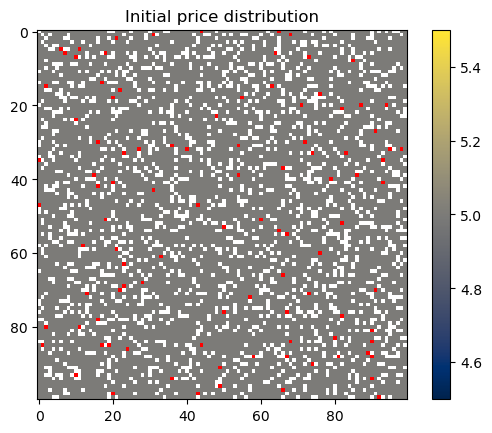

Initial affluence distribution:


array([[nan, 0.1, 0.5, ..., nan, 0.5, 0.1],
       [0.5, nan, 0.1, ..., 0.5, nan, 0.1],
       [0.5, 0.1, nan, ..., 0.5, 0.5, 1. ],
       ...,
       [0.1, 0.5, 0.1, ..., 0.5, 0.1, 1. ],
       [0.5, 1. , 1. , ..., 0.5, 0.5, 0.1],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]])

In [7]:
# Set board size
m = 100
n = 100

# Set parameters
a = [1,0.5,0.1] # Affluence group parameters 
p = [0.1, 0.4, 0.5] # Initial affluence proportions 
v = 5 # Initial house price
weights = [0.75, 0.75] # Inflationary parameter and amenities parameter
empty_ratio = 0.2 # Proportion of grid empty
amenities = m # Number of amenities
r = 4 # Radius to consider amenities in

# Initialize house price grid 
initial_prices = initial_price_dist(m, n, v, amenities, empty_ratio)

display(initial_prices)
plot_grid(initial_prices)
plt.title("Initial price distribution")
plt.show()

print("Initial affluence distribution:")
# Initialize affluence grid 
affluence_grid = initial_affluence_dist(initial_prices, a, p)
display(affluence_grid)

Testing first house values calculation:


array([[ nan, 3.85, 4.25, ...,  nan, 4.25, 3.85],
       [4.25,  nan, 3.85, ..., 4.25,  nan, 3.85],
       [4.25, 3.85,  nan, ..., 4.25, 4.25, 4.75],
       ...,
       [3.85, 4.25, 3.85, ..., 4.25, 3.85, 4.75],
       [4.25, 4.75, 4.75, ..., 4.25, 4.25, 3.85],
       [4.25, 4.25, 4.25, ..., 4.25, 4.25, 4.25]])

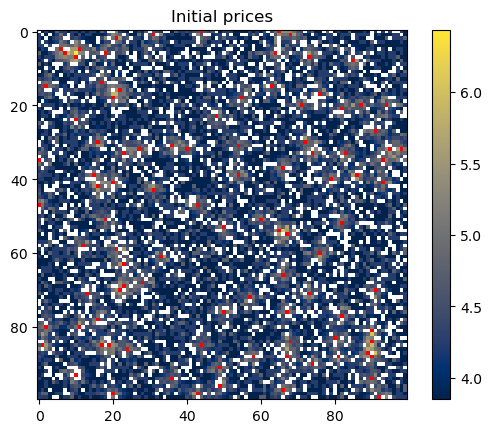

In [8]:
# Test the new functions

house_vals = update_house_prices(initial_prices, affluence_grid, weights, r) 
# Plot the initial house values 
fig, ax = plt.subplots()
img = plot_grid(house_vals)
plt.title(f"Initial prices")

print("Testing first house values calculation:")
display(house_vals)

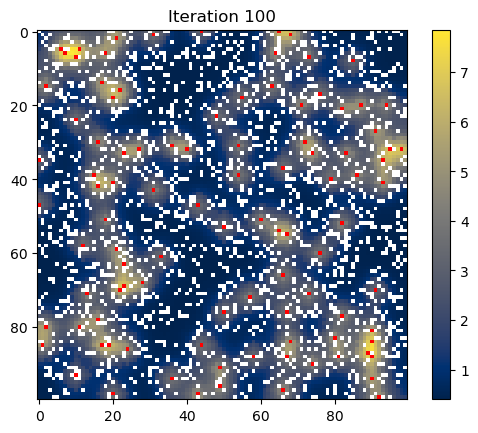

In [9]:
# Animation cell 

# Plot the initial house values 
fig, ax = plt.subplots()
img = plot_grid(house_vals)
plt.title(f"Initial prices")
plt.pause(0.5) 
clear_output(wait=True) 

# Plot the iterations 
n_steps = 100
for i in range(n_steps):
   house_vals, affluence_grid = new_iteration(house_vals, affluence_grid)
   img = plot_grid(house_vals)  
   plt.title(f"Iteration {i + 1}")
   plt.pause(0.001)  
   clear_output(wait=True) 

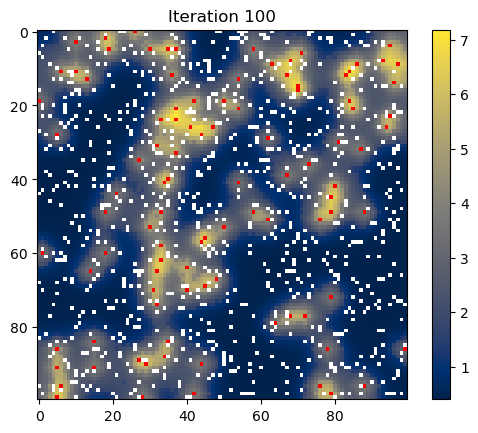

In [10]:
# Test adding houses and modifying houses functions

# Initialize house price grid 
initial_prices = initial_price_dist(m, n, v, amenities, empty_ratio)

# Initialize affluence grid 
affluence_grid = initial_affluence_dist(initial_prices, a, p)

house_vals = update_house_prices(initial_prices, affluence_grid, weights, r) 
# Plot the initial house values 
fig, ax = plt.subplots()
img = plot_grid(house_vals)
plt.title(f"Initial prices")

# Plot the initial house values 
fig, ax = plt.subplots()
img = plot_grid(house_vals)
plt.title(f"Initial prices")
plt.pause(0.5) 
clear_output(wait=True) 

# Plot the iterations 
# Add 1000 random houses with price 5 at iteration 25
# Modify 1000 random existing houses to price 10 at iteration 50
n_steps = 100
for i in range(n_steps):
    if i == 25:
        house_vals, affluence_grid = add_new_houses(
            house_vals, affluence_grid, a, p, num_houses=1000, random=True, pos=None, value=5
            )
    if i == 50:
        house_vals = modify_existing_prices(
            house_vals, num_houses=1000, random=True, pos=None, new_value=10
        )
    house_vals, affluence_grid = new_iteration(house_vals, affluence_grid)
    img = plot_grid(house_vals)  
    plt.title(f"Iteration {i + 1}")
    plt.pause(0.001)  
    clear_output(wait=True) 